## Loading

In [1]:
from pandas import read_csv
import numpy as np

measurments = read_csv('data/driving_log.csv', usecols=[3]).values
C = measurments
L = measurments + 0.2
R = measurments - 0.2
#measurments = np.concatenate((C, L, R, -C, -L, -R), axis=0)

In [2]:
images_C = read_csv('data/driving_log.csv', usecols=[0]).values
images_L = read_csv('data/driving_log.csv', usecols=[1]).values
images_R = read_csv('data/driving_log.csv', usecols=[2]).values
#images_path = np.concatenate((images_C, images_L, images_R), axis=0)

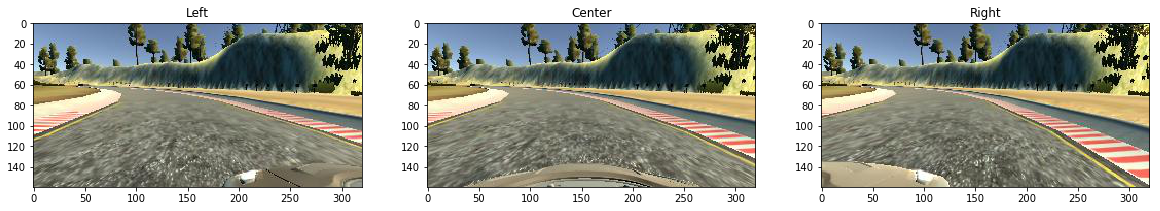

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread

fig = plt.figure(figsize=(20,10))

a=fig.add_subplot(1,3,1)
a.set_title('Left')
left = imread(images_L[0,0])
plt.imshow(left)

a=fig.add_subplot(1,3,2)
a.set_title('Center')
center = imread(images_C[0,0])
plt.imshow(center)

a=fig.add_subplot(1,3,3)
a.set_title('Right')
right = imread(images_R[0,0])
plt.imshow(right)


In [3]:
from sklearn.utils import shuffle
from matplotlib.image import imread

def genImages(idx, size):
    images = []
    
    for path in images_C[idx:idx+size]:
        fname = 'data/IMG/'+ path[0].split('/')[-1]
        images.append(imread(fname))
        
    for path in images_L[idx:idx+size]:
        fname = 'data/IMG/'+ path[0].split('/')[-1]
        images.append(imread(fname))
        
    for path in images_R[idx:idx+size]:
        fname = 'data/IMG/'+ path[0].split('/')[-1]
        images.append(imread(fname))

    images = np.array(images)
    images = np.concatenate((images, np.fliplr(images)), axis=0)
    
    measurments = np.concatenate((C[idx:idx+size], L[idx:idx+size], R[idx:idx+size],
                                  -C[idx:idx+size], -L[idx:idx+size], -R[idx:idx+size]), axis=0)
    
    X_train, Y_train = shuffle(images, measurments)
    return X_train, Y_train

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Lambda, Cropping2D, MaxPooling2D

def model():
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))

    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))

    model.compile('adam', "mse")
    
    return model

Using TensorFlow backend.


In [5]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.001)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
tensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

EPOCHS = 1
BATCH_SIZE = 600

model = model()

size = 2500
for i in range(10):
    print('='*51)
    print('='*24, i+1, '='*24)
    print('='*51)
    for idx in range(10):
        X_train, Y_train = genImages(idx*size, size)
        model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, validation_split=0.2)

======================== 1 ========================
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 23s - loss: 0.0335 - val_loss: 0.0305

In [6]:
model.save('model.h5')